In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Plotting travel time distributions and incident counts

In [8]:
sdf = pd.read_csv("./data/stations.csv")
cov = pd.read_csv("./logs/station_report.csv")
sim = pd.read_csv("./logs/near_station_report.csv")

cov = pd.merge(cov, sdf[["StationID", "Facility Name"]], on="StationID", how="left")
sim = pd.merge(sim, sdf[["StationID", "Facility Name"]], on="StationID", how="left")

cov.TravelTime.mean(), sim.TravelTime.mean()

(np.float64(249.6014795144158), np.float64(235.3716346153846))

In [5]:
def get_helped_metrics(sim):
    incident_station_counts = sim.groupby('IncidentID')['StationID'].nunique()
    multi_station_incidents = incident_station_counts[incident_station_counts > 1].index
    helped_sim = sim[sim['IncidentID'].isin(multi_station_incidents)]
    # display(helped_sim)
    # Filter sim for only those incidents
    helped_sim = sim[sim['IncidentID'].isin(multi_station_incidents)]

    # For each incident, find the first station (assumed to be the one being helped)
    primary_stations = helped_sim.groupby('IncidentID').first()['StationID']
    # Create a DataFrame from the station_helped_counts and sort by StationID
    station_helped_df = primary_stations.value_counts().sort_index().reset_index()
    station_helped_df.columns = ['StationID', 'TimesHelped']
    # display(station_helped_df.head())
    station_helped_df.sum()
    shelped = pd.merge(station_helped_df, sdf[["StationID", "Facility Name"]], how='right')
    shelped['TimesHelped'] = shelped['TimesHelped'].fillna(0)
    shelped['TimesHelped'] = shelped['TimesHelped'].astype('int')
    return shelped

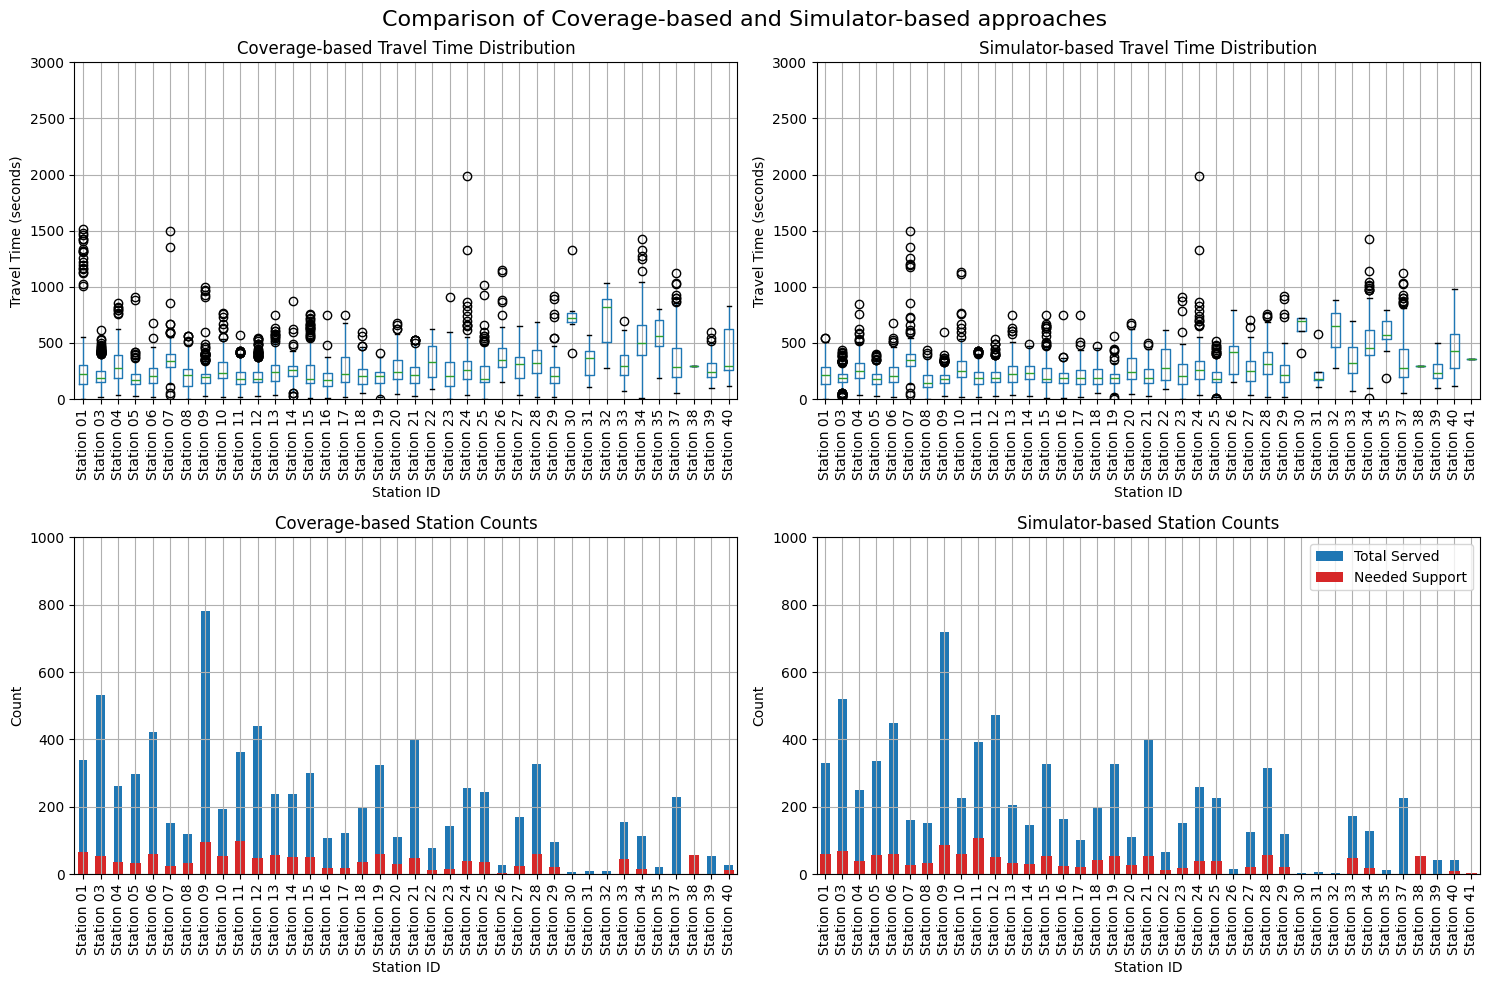

In [6]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(15, 10))
axs = np.array(axs)
axs = axs.reshape(-1)
# Convert to using ax[0] and ax[1] for subplots
cov.boxplot(column='TravelTime', by='Facility Name', ax=axs[0], rot=90)
axs[0].set_title('Coverage-based Travel Time Distribution')
axs[0].set_xlabel('Station ID')
axs[0].set_ylabel('Travel Time (seconds)')

sim.boxplot(column='TravelTime', by='Facility Name', ax=axs[1], rot=90)
axs[1].set_title('Simulator-based Travel Time Distribution')
axs[1].set_xlabel('Station ID')
axs[1].set_ylabel('Travel Time (seconds)')

axs[0].set_ylim(0, 3000)
axs[1].set_ylim(0, 3000)

coverage_counts = cov['Facility Name'].value_counts().sort_index()
simulator_counts = sim['Facility Name'].value_counts().sort_index()

coverage_counts.plot(kind='bar', ax=axs[2], label='Total Served')
shelped = get_helped_metrics(cov)
shelped_sorted = shelped.sort_values('Facility Name')
axs[2].bar(shelped_sorted['Facility Name'], shelped_sorted['TimesHelped'], 
           color='tab:red', alpha=1.0, label='Needed Support', width=0.6)

axs[2].set_title('Coverage-based Station Counts')
axs[2].set_xlabel('Station ID')
axs[2].set_ylabel('Count')
axs[2].set_xticklabels(coverage_counts.index, rotation=90)

simulator_counts.plot(kind='bar', ax=axs[3], label='Total Served')

# Overlay shelped['TimesHelped'] as red bars (make sure index matches)
shelped = get_helped_metrics(sim)
shelped_sorted = shelped.sort_values('Facility Name')
axs[3].bar(shelped_sorted['Facility Name'], shelped_sorted['TimesHelped'], 
           color='tab:red', alpha=1.0, label='Needed Support', width=0.6)

axs[3].set_title('Simulator-based Station Counts')
axs[3].set_xlabel('Station ID')
axs[3].set_ylabel('Count')
axs[3].set_xticklabels(simulator_counts.index, rotation=90)

axs[2].set_ylim(0, 1000)
axs[3].set_ylim(0, 1000)

axs[2].grid(axis='y')
axs[3].grid(axis='y')
axs[2].grid(axis='x')
axs[3].grid(axis='x')
plt.legend()
plt.suptitle('Comparison of Coverage-based and Simulator-based approaches', fontsize=16)
plt.tight_layout()
plt.savefig("logs/dist.png", dpi=300)


In [78]:
incident_station_counts = sim.groupby('IncidentID')['StationID'].nunique()
multi_station_incidents = incident_station_counts[incident_station_counts > 1].index
helped_sim = sim[sim['IncidentID'].isin(multi_station_incidents)]

# Plotting incident locations and station locations

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
# add contextily
# Add a basemap with contextily
import contextily as ctx

# show all columns
pd.set_option('display.max_columns', None)

df = pd.read_csv("logs/incident_report.csv")
incidents = pd.read_csv("data/incidents.csv")
stations = pd.read_csv("data/stations.csv")
stations = stations.rename(columns={
    'lat': 'stations_lat',
    'lon': 'stations_lon'
})
df = pd.merge(df, incidents, left_on='IncidentID', right_on='incident_id', how='left')
df = pd.merge(df, stations, on='StationID', how='left')

# plot the incidents and stations on a map
stations_gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.stations_lon, df.stations_lat), crs="EPSG:4326"
)
stations_gdf.drop_duplicates(subset=['StationID'], inplace=True)

incidents_gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.lon, df.lat), crs="EPSG:4326"
)

fig, ax = plt.subplots(figsize=(10, 10))
stations_gdf.plot(ax=ax, color='blue', markersize=5, label='Stations')
# station_id = 33
# stations_gdf[stations_gdf['StationID'] == station_id].plot(ax=ax, color='red', markersize=10, label='Station')
# incidents_gdf[incidents_gdf['StationID'] == station_id].plot(ax=ax, color='black', markersize=10, label='Incidents')
stations_gdf.plot(ax=ax, column="StationID", cmap="Set1", markersize=10, label='Station')
incidents_gdf.plot(ax=ax, column="StationID", cmap="Set1", markersize=10, label='Incidents')

# add text to stations
for x, y, label in zip(stations_gdf.geometry.x, stations_gdf.geometry.y, stations_gdf['StationID']):
    ax.text(x, y, label, fontsize=15, ha='right', va='bottom', color='blue')
for x, y, label in zip(incidents_gdf.geometry.x, incidents_gdf.geometry.y, incidents_gdf['StationID']):
    ax.text(x, y, label, fontsize=8, ha='right', va='bottom', color='blue')

ctx.add_basemap(ax,
               crs=stations_gdf.crs.to_string(),
               source=ctx.providers.CartoDB.Voyager
              )
